In [1]:
%pip install tensorflow-datasets

  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl (5.3 MB)
  Using cached etils-1.11.0-py3-none-any.whl (165 kB)
  Using cached dm_tree-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (152 kB)
  Using cached immutabledict-4.2.1-py3-none-any.whl (4.7 kB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached pyarrow-18.1.0-cp311-cp311-manylinux_2_28_x86_64.whl (40.1 MB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached array_record-0.5.1-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (2.2 MB)
  Using cached tensorflow_metadata-1.16.1-py3-none-any.whl (28 kB)
  Using cached simple_parsing-0.1.6-py3-none-any.whl (112 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached importlib_resources-6.4.5-py3-none-any.whl (36 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl (36 kB)
  Using cached googl

In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

from clearml import Dataset
from tensorflow import keras
from tensorflow.keras import layers

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

def analyze(model):
    print('='*21, ' Model Info', '='*21)
    trainableParams = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    nonTrainableParams = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    totalParams = trainableParams + nonTrainableParams
    totalFlops = get_flops(model)
    
    print('Trainable params:',trainableParams)
    print('Nontrainable params:',nonTrainableParams)
    print('Total params:', totalParams)
    print('Flops:', totalFlops)
    print('='*21, 'End of Info', '='*21)
    return {
        'trainableParams':trainableParams, 
        'nonTrainableParams': nonTrainableParams, 
        'totalParams': totalParams, 
        'totalFlops': totalFlops,
    }
    

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

data_path = Dataset.get(dataset_id='fa15e4e3e9e745d59d27a7062ce4cf37').get_local_copy()
print(data_path)
(ds, val_ds), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
    with_info=True,
    data_dir=data_path,
    download=False
)
ds = ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.cache().shuffle(ds_info.splits['train'].num_examples).batch(128).prefetch(tf.data.experimental.AUTOTUNE)

# val_ds = tfds.load(
#     'cifar100',
#     split='test',
#     as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
#     with_info=False,
# )
val_ds = val_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(128).prefetch(tf.data.experimental.AUTOTUNE)

I0000 00:00:1734616299.694582    6693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734616299.694719    6693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734616299.694806    6693 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734616299.743393    6693 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
ds_info.features

FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
})

(128, 32, 32, 3) (128,)


NameError: name 'model' is not defined

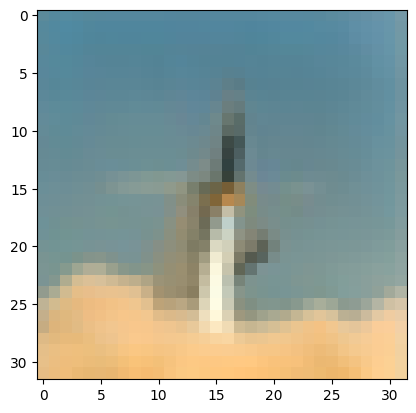

In [5]:
img = ds.take(1)
for i in img:
    print(i[0].shape, i[1].shape)
    plt.imshow(tf.cast(i[0][0]*255, tf.uint8))
    print(tf.reduce_sum(model(i[:1]), axis=1))
# model(img)

In [128]:
histories=[]
models = [
    (keras.applications.ResNet50V2, 'ResNet50V2'),
    # (keras.applications.InceptionV3, 'InceptionV3'),
    (keras.applications.DenseNet121, 'DenseNet121'),
    (keras.applications.EfficientNetV2B0, 'efficientnetv2-b0'),
]
for m, n in models:
    model = m(
        include_top=True,
        weights=None,
        # input_tensor=None,
        input_shape=ds_info.features['image'].shape,
        pooling=None,
        classes=ds_info.features['label'].num_classes,
        classifier_activation="softmax",
        name=n,
    )
    # model.summary()
    analyze(model)
    # model.compile(
    #     optimizer=keras.optimizers.AdamW(),
    #     loss=keras.losses.SparseCategoricalCrossentropy(),
    #     metrics=[keras.metrics.SparseCategoricalAccuracy()],
    # )
    # history = model.fit(ds, epochs=30, validation_data=val_ds)
    # histories.append(history)

=====================  Model Info =====================
Trainable params: 23724260
Nontrainable params: 45440
Total params: 23769700


I0000 00:00:1734544820.682878    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544820.683021    1386 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 18:00:20.683078: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1734544820.683271    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544820.683388    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

I0000 00:00:1734544824.291501    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544824.291643    1386 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 18:00:24.291708: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1734544824.292048    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544824.292148    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

I0000 00:00:1734544829.563171    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544829.563324    1386 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-12-18 18:00:29.563407: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1734544829.563585    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734544829.563685    1386 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so


=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th

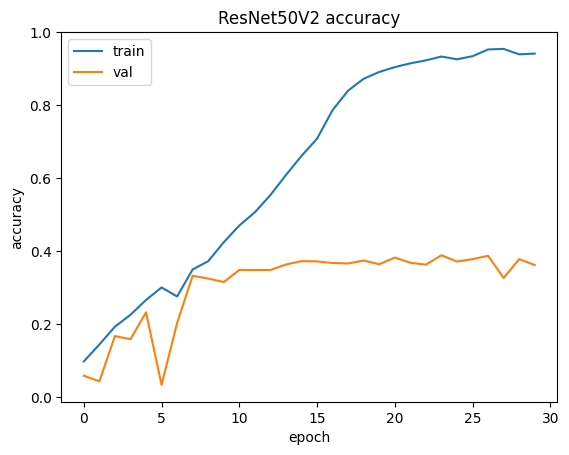

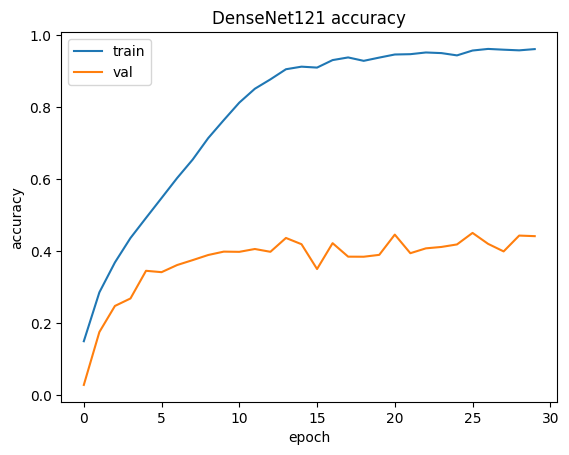

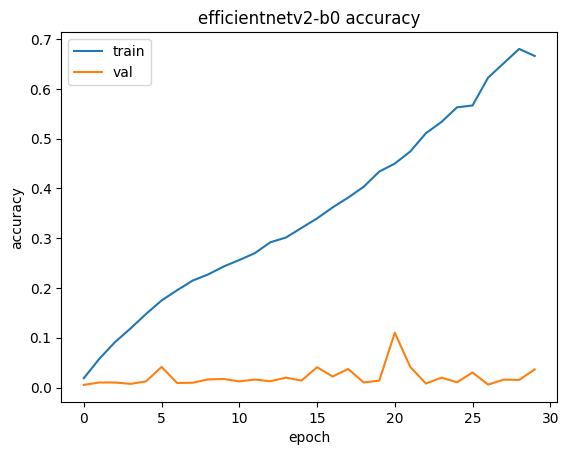

In [110]:
for h, (m,n) in zip(histories[1:], models):
    plt.plot(h.history['sparse_categorical_accuracy'])
    plt.plot(h.history['val_sparse_categorical_accuracy'])
    plt.title(f'{n} accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [77]:
q = tf.convert_to_tensor(np.arange(5).reshape(1,5), tf.float32)
k = tf.convert_to_tensor(np.arange(5,10).reshape(1,5), tf.float32)
v = tf.convert_to_tensor(np.arange(10,15).reshape(1,5), tf.float32)

In [78]:
q

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0., 1., 2., 3., 4.]], dtype=float32)>

In [79]:
tf.transpose(k)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[5.],
       [6.],
       [7.],
       [8.],
       [9.]], dtype=float32)>

In [81]:
tf.transpose(k)@q

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[ 0.,  5., 10., 15., 20.],
       [ 0.,  6., 12., 18., 24.],
       [ 0.,  7., 14., 21., 28.],
       [ 0.,  8., 16., 24., 32.],
       [ 0.,  9., 18., 27., 36.]], dtype=float32)>

In [6]:
@tf.keras.utils.register_keras_serializable()
class Conv_Block(tf.keras.layers.Layer):
    def __init__(self, kernel, filters, stride, activation=tf.nn.relu6, **kwargs):
        super(Conv_Block, self).__init__(**kwargs)
        self.kernel = kernel
        self.filters = filters
        self.activation = activation
        self.stride = stride

    def get_config(self):
        config = super().get_config()
        config.update({
            'kernel': self.kernel,
            'filters': self.filters,
            'stride': self.stride,
            'activation': self.activation
        })
        return config

    def build(self, input_shape):
        self.bn1 = layers.BatchNormalization()
        self.conv = layers.SeparableConv2D(self.filters,self.kernel,self.stride,'same',activation=self.activation)
    
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn1(x)
        return x


@tf.keras.utils.register_keras_serializable()
class VOV_Block(tf.keras.layers.Layer):
    def __init__(self, filters_out, n_layers, layer_filter=None, activation='relu6', ese=None, identity=False, use_mobile=False, **kwargs):
        super(VOV_Block, self).__init__(**kwargs)
        self.filters_out = filters_out
        self.n_layers = n_layers
        self.layer_filter = layer_filter
        self.activation = activation
        self.identity = identity
        self.use_mobile = use_mobile
        self.ese = ese
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'filters_out': self.filters_out,
            'layer_filter': self.layer_filter,
            'n_layers': self.n_layers,
            'activation': self.activation,
            'ese': self.ese,
            'identity': self.identity,
            'use_mobile': self.use_mobile,
        })
        return config

    # input shape requires channel last
    def build(self, input_shape): 
        n  = self.layer_filter if self.layer_filter is not None else input_shape[-1]
        if (self.use_mobile):
            self.convs = [Conv_Block(3, n, 1, activation=self.activation) for _ in range(self.n_layers)]
        else:
            self.convs = [layers.Conv2D(n, 3, padding='same', activation=self.activation) for _ in range(self.n_layers)]
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.conv_out = layers.Conv2D(self.filters_out, 1, padding='same', activation=self.activation)
        if (self.identity):
            self.add = layers.Add()

    def call(self, inputs):
        x = inputs
        layers = [x]
        for c in self.convs:
            x = c(x)
            layers += [x]
        x = self.concat(layers)
        out = self.conv_out(x)
        if (self.ese):
            out = self.ese(out)
        if (self.identity):
            out = self.add([inputs, out])
        return out


In [28]:
def make_model(activation='relu6', ese_layer=lambda *args: None, name='27slim'):
    # with tf.Graph().as_default():
    inp = tf.keras.Input(ds_info.features['image'].shape,name='input')
    ### stage 1
    x = layers.Conv2D(64, 3, strides=2, padding='valid', activation=activation)(inp)
    x = layers.Conv2D(64, 3, strides=1, padding='valid', activation=activation)(x)
    x = layers.Conv2D(128, 3, strides=1, padding='valid', activation=activation)(x)
    ### stage 2
    x = VOV_Block(128, 5, 64, identity=True)(x)#, ese=ese_layer())(x)
    x = layers.MaxPool2D(3, 2)(x)
    ### stage 3
    x = VOV_Block(256, 5, 80, ese=ese_layer())(x)
    x = layers.MaxPool2D(3, 2)(x)
    ### stage 4
    x = VOV_Block(384, 5, 96)(x)#, ese=ese_layer())(x)
    x = layers.MaxPool2D(2, 1)(x)
    ### stage 5
    x = VOV_Block(512, 5, 112)(x)#, ese=ese_layer())(x)
    ### out
    out = layers.GlobalAveragePooling2D('channels_last')(x)
    out = layers.Dense(ds_info.features['label'].num_classes)(out)
    out = layers.Softmax(name='softmax_out')(out)
    
    model = tf.keras.Model(inputs=[inp], outputs=[out], name=f"vovnet_{name}")
    return model

In [29]:
@tf.keras.utils.register_keras_serializable()
class SE_Block(tf.keras.layers.Layer):
    def __init__(self, reduction_factor=4, score_only=False, **kwargs):
        super(SE_Block, self).__init__(**kwargs)
        self.reduction_factor = reduction_factor
        self.score_only = score_only

    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_factor': self.reduction_factor,
            'score_only': self.score_only
        })
        return config

    def build(self, input_shape):
        input_channels = int(input_shape[-1])
        self.pool = layers.GlobalAveragePooling2D()
        self.d1 = layers.Dense(input_channels//self.reduction_factor, activation='relu6')
        self.d2 = layers.Dense(input_channels, activation='hard_sigmoid')
        self.reshape = layers.Reshape((1, 1, input_channels))
        self.out = layers.Multiply()

    def call(self, inputs):
        x = self.pool(inputs)
        x = self.d1(x)
        x = self.d2(x)
        x = self.reshape(x)
        if (self.score_only):
            return x
        else:
            return self.out([inputs, x])
        
@tf.keras.utils.register_keras_serializable()
class SelfAttention_Block(tf.keras.layers.Layer):
    def __init__(self, reduction_factor=1, mode='add', **kwargs):
        super(SelfAttention_Block, self).__init__(**kwargs)
        self.reduction_factor = reduction_factor
        self.mode = mode
        assert self.mode in ['add', 'sigmoid', 'no_op']
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_factor': self.reduction_factor,
            'mode': self.mode
        })
        return config
        
    # input shape requires channel last
    def build(self, input_shape): 
        n = input_shape[-1]
        r = self.reduction_factor
        self.query = layers.Conv2D(n//r, 1, padding='same', use_bias=False)
        self.key = layers.Conv2D(n//r, 1, padding='same', use_bias=False)
        self.value = layers.Conv2D(n, 1, padding='same', use_bias=False)
        self.reshape1 = tf.keras.layers.Reshape((-1, n//r))
        self.reshape2 = tf.keras.layers.Reshape((-1, n))
        self.gamma = tf.Variable(0, trainable=True, dtype=tf.float32)
        self.softmax = layers.Softmax(axis=1)

    def call(self, x):
        size = tf.shape(x)
        f, g, h = self.query(x), self.key(x), self.value(x)
        f, g, h = self.reshape1(f), self.reshape1(g), self.reshape2(h)
        beta = self.softmax(tf.matmul(f, tf.transpose(g, perm=[0,2,1])))
        beta = tf.reshape(tf.matmul(h, beta, transpose_a=True), size) 
        if (self.mode=='add'):
            return self.gamma * beta + x   
        elif (self.mode=='sigmoid'):
            return tf.sigmoid(self.gamma * beta) * x   
        else:
            return self.gamma * beta  

@tf.keras.utils.register_keras_serializable()
class DualSelfAttention_Block(tf.keras.layers.Layer):
    def __init__(self, reduction_factor=1, identity=False, **kwargs):
        super(DualSelfAttention_Block, self).__init__(**kwargs)
        self.reduction_factor = reduction_factor
        self.identity = identity
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'reduction_factor': self.reduction_factor,
            'identity': self.identity
        })
        return config
        
    # input shape requires channel last
    def build(self, input_shape): 
        n = input_shape[-1]
        r = self.reduction_factor
        self.p_query =  layers.Conv2D(n//r, 1, padding='same', use_bias=False, activation='relu')
        self.p_key   =  layers.Conv2D(n//r, 1, padding='same', use_bias=False, activation='relu')
        self.p_value =  layers.Conv2D(n, 1, padding='same', use_bias=False, activation='relu')
        self.c_conv  =  layers.Conv2D(n, 1, padding='same', use_bias=False, activation='relu')
        self.reshape1 = tf.keras.layers.Reshape((-1, n//r))
        self.reshape2 = tf.keras.layers.Reshape((-1, n))
        self.position_attention =   layers.Attention(use_scale=True)
        self.channel_attention  =   layers.Attention(use_scale=True)
        self.fuse = layers.Add()

    def call(self, x):
        q, k, v = self.p_query(x), self.p_key(x), self.p_value(x)
        q, k, v = self.reshape1(q), self.reshape1(k), self.reshape2(v)
        pa = self.position_attention([q, v, k])
        pa = tf.reshape(pa, tf.shape(x)) 
        xt = tf.transpose(self.c_conv(x), [0, 3, 1, 2])
        ca = self.channel_attention([xt, xt, xt])
        ca = tf.transpose(ca, [0, 2, 3, 1])
        if self.identity == True:
            return self.fuse([x, pa, ca])
        else:
            return self.fuse([pa, ca])


Model: "vovnet_27slim"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_363 (Conv2D)             │ (None, 15, 15, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_364 (Conv2D)             │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_365 (Conv2D)             │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_44 (VOV_Block)       │ (None, 11, 11, 128)    │       278,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_45 (VOV_Block)       │ (None, 5, 5, 256)      │       654,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_46 (VOV_Block)       │ (None, 2, 2, 384)      │       836,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 1, 1, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vov__block_47 (VOV_Block)       │ (None, 1, 1, 512)      │     1,323,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_out (Softmax)           │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,257,348 (12.43 MB)

 Trainable params: 3,257,348 (12.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 4.4576 - sparse_categorical_accuracy: 0.0223 - val_loss: 3.9690 - val_sparse_categorical_accuracy: 0.0748
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.8823 - sparse_categorical_accuracy: 0.0898 - val_loss: 3.5866 - val_sparse_categorical_accuracy: 0.1478
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.5187 - sparse_categorical_accuracy: 0.1526 - val_loss: 3.3049 - val_sparse_categorical_accuracy: 0.1971
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 3.1753 - sparse_categorical_accuracy: 0.2195 - val_loss: 3.0596 - val_sparse_categorical_accuracy: 0.2445
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.9160 - sparse_categorical_accuracy: 0.2642 - val_loss: 2.8954 - val_sparse_categorical_accuracy: 0.2759
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 2.6739 - sparse_categorical_accuracy: 0.3140 - val_loss: 2.7242 - val_sparse_categorical_accuracy: 0.31

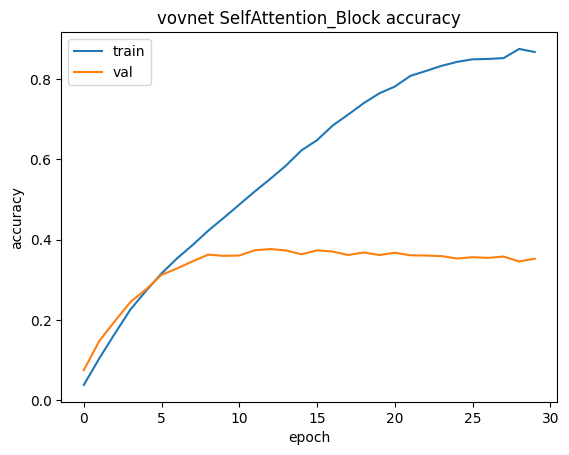

In [30]:
se = SE_Block
sa = SelfAttention_Block
dsa = DualSelfAttention_Block
# attens = [se, sa, dsa]
# attens = [dsa]
# attens = [se, lambda *_:sa(mode='add'), lambda *_:sa(mode='sigmoid')]
attens = [sa]
for a in attens:
    tf.compat.v1.reset_default_graph()
    with tf.name_scope("vovnet") as scope:
        model = make_model(ese_layer=a)
        model.summary()
        # analyze(model)
        model.compile(
            optimizer=keras.optimizers.AdamW(),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )
        history = model.fit(ds, epochs=30, validation_data=val_ds)
        plt.plot(history.history['sparse_categorical_accuracy'])
        plt.plot(history.history['val_sparse_categorical_accuracy'])
        plt.title(f'vovnet {a.__name__} accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

In [131]:
import gc
del model 
tf.keras.backend.clear_session()
gc.collect()

0